<IPython.core.display.Javascript object>


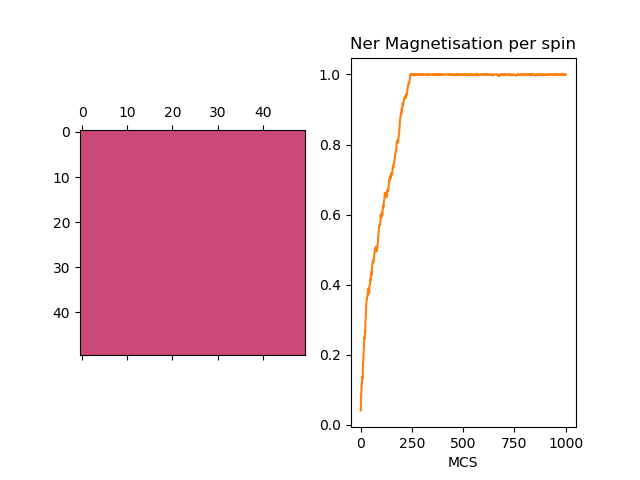

1      0.0416
2      0.0856
3      0.084
4      0.0984
5      0.1168
6      0.116
7      0.1248
8      0.1344
9      0.1376
10      0.1328
11      0.1672
12      0.1776
13      0.1792
14      0.2
15      0.2128
16      0.2184
17      0.2312
18      0.2496
19      0.2464
20      0.2496
21      0.2576
22      0.2688
23      0.2648
24      0.2976
25      0.304
26      0.3248
27      0.3392
28      0.348
29      0.3536
30      0.36
31      0.3592
32      0.3648
33      0.3664
34      0.3704
35      0.3696
36      0.3872
37      0.3768
38      0.3824
39      0.3776
40      0.3904
41      0.3816
42      0.3752
43      0.396
44      0.3984
45      0.4
46      0.4016
47      0.4064
48      0.4152
49      0.4112
50      0.4272
51      0.4328
52      0.4368
53      0.436
54      0.428
55      0.4424
56      0.448
57      0.4544
58      0.4568
59      0.4664
60      0.4664
61      0.4696
62      0.464
63      0.468
64      0.4728
65      0.4728
66      0.4816
67      0.4888
68      0.4912
69     

552      0.9992
553      1.0
554      0.9992
555      0.9992
556      0.9984
557      0.9984
558      0.9992
559      0.9992
560      1.0
561      0.9992
562      0.9984
563      0.9992
564      1.0
565      0.9976
566      0.9992
567      1.0
568      1.0
569      1.0
570      0.9992
571      0.9984
572      1.0
573      1.0
574      0.9992
575      0.9976
576      0.9984
577      0.9984
578      0.9984
579      0.9984
580      0.9984
581      0.9984
582      0.9984
583      0.9984
584      1.0
585      1.0
586      1.0
587      1.0
588      0.9992
589      1.0
590      1.0
591      1.0
592      1.0
593      1.0
594      1.0
595      0.9992
596      0.9992
597      1.0
598      1.0
599      1.0
600      1.0
601      1.0
602      1.0
603      1.0
604      0.9984
605      0.9992
606      1.0
607      1.0
608      0.9992
609      0.9984
610      0.9992
611      0.9984
612      0.9992
613      0.9992
614      0.9992
615      1.0
616      0.9992
617      1.0
618      1.0
619      1.0
620  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import njit
%matplotlib notebook

def largest_primes_under(N):
    n = N - 1
    while n >= 2:
        if all(n % d for d in range(2, int(n ** 0.5 + 1))):
            return n
        n -= 1

@njit
def Neighbors(Lattice,i,j,n=1):
    ''' Returns an flat array of all neighboring sites in the n-th coordination sphere including the center'''
    N, M = Lattice.shape
    rows = np.array([(i-1) % N, i, (i+1) % N])
    cols = np.array([(j-1) % N, j, (j+1) % M])
    return Lattice[rows,:][:,cols].flatten()

@njit
def calc_dE(Lattice, x, y, z):
    N, M = Lattice.shape
    old_energy = 0
    new_energy = 0
    for i in [0,1,-1]:
        for j in [0,1,-1]:
            if i == 0 and j == 0: 
                continue
            if Lattice[x%N,y%M] == Lattice[(x+i)%N,(y+j)%M]:
                old_energy += 1
            elif z == Lattice[(x+i)%N,(y+j)%M]: 
                new_energy += 1 
    return old_energy-new_energy

N, M = 50,50
beta = 1.0/1.0  # Set beta factor in units of energy/temperature (1/beta = 2.27 is Curie temp)
orientations = 2
MCS = int(1000)

a = largest_primes_under(N*M)
L = np.random.randint(1,orientations+1,size=(N,M))
ims=[]
mag=[]
mcs=[]

fig, axs = plt.subplots(nrows=1, ncols=2)
mat = axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser')
mvt = axs[1].plot(mcs,mag)
axs[1].set(title='Ner Magnetisation per spin', xlabel='MCS')

for t in range(1,MCS+1):
    rand = np.random.randint(N*M)
    for i in range(0,N**2):
        index = (a*i + rand) % (N**2)
        x = index % N
        y = index // N
        n = Neighbors(L,x,y)
        if len(n)-1 == 0: 
            continue
        else: 
            z = np.random.choice(orientations)+1
        dE = calc_dE(L,x,y,z)
        if  (dE < 0): 
            L[x%N,y%N] = z      
        elif np.random.sample() < np.exp(-dE*beta): 
            L[x%N,y%N] = z
           
    ims.append((axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser'),))
    
    mcs.append(t)
    mag.append((np.sum(np.where(L==1,1,0))-np.sum(np.where(L==2,1,0)))/(N*M))
    print(mcs[t-1],"    ",mag[t-1])  # Print net magnetisation per spin

ani = animation.ArtistAnimation(fig,ims,interval=100,blit=True)
lines = axs[1].plot(mcs,mag)
fig.show()